EVA Session 9 Assignment - Part 1 : Kaustubh M Harapanahalli

# Importing the necessary libraries and packages

In [1]:
from keras.preprocessing import image

from keras.models import Model, load_model
from keras.datasets import cifar10
import keras.backend as K

import numpy as np
import cv2
import sys
import imageio

import matplotlib.pyplot as plt

Using TensorFlow backend.


# Loading Google Drive for accessing saved model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Loading the best saved model

In [3]:
model = load_model('drive/My Drive/EVA/Assignment 6/saved_models/weights-improvement-31-0.8493.hdf5')

W0626 05:14:09.259882 140320893269888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0626 05:14:09.358277 140320893269888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0626 05:14:09.418274 140320893269888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0626 05:14:09.420134 140320893269888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0626 05:14:09.423026 140320893

# Loading the dataset

In [4]:
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 96)        27744     
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 96)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 96)        384       
__________

# Selecting images to perform gradCAM

In [0]:
images = [test_features[10], test_features[512], test_features[1024], test_features[2048]]

In [0]:
image = []

for i in images: 
    x = i
    x1 = np.expand_dims(x, axis=0)
    x1 = x1 / x1.mean()
    preds = model.predict(x1)
    class_idx = np.argmax(preds[0]) 
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer("conv2d_8")
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x1])
    for i in range(32):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    img = x
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    
    image.append(img)
    image.append(superimposed_img)
    image.append(heatmap)

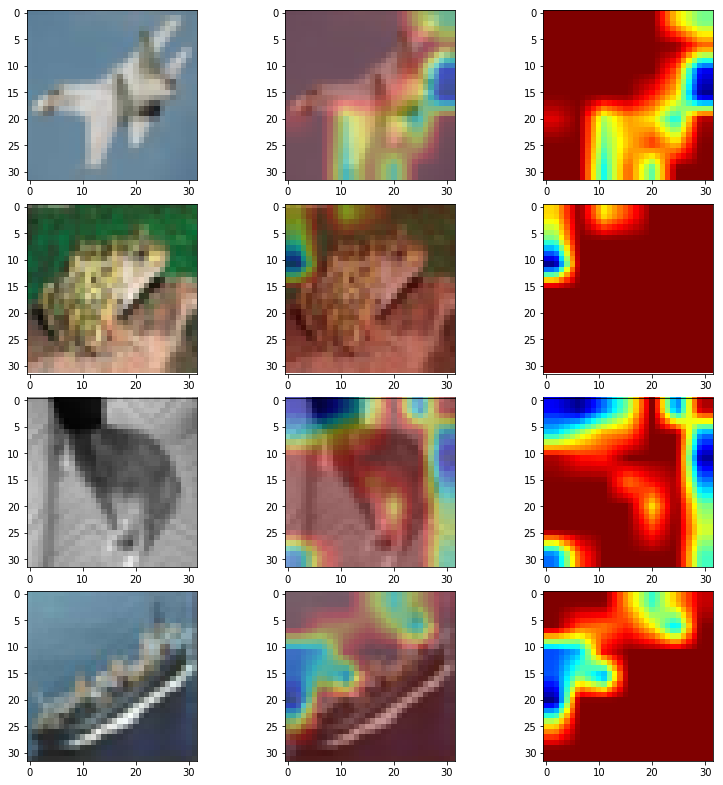

In [8]:
fig, ax = plt.subplots(4, 3, figsize = (12, 12))

fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
j = 0
    
for row in ax:
    for col in row:
        if j < len(image):
            col.imshow(image[j].astype(int))
            j+=1